# Building the distributed seismicity model

Notes:
* The catalogue used for the smoothing contains only earthquakes with magnitude larger than the 'cutoff_magnitude' parameter defined in the .ini file of the project

In [ ]:
%%html
<script>
    var code_show=true; //true -> hide code at first

    function code_toggle() {
        $('div.prompt').hide(); // always hide prompt

        if (code_show){
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>
<p style="font-size:60%;">
<a href="javascript:code_toggle()">[Toggle Code]</a>
<a target="_blank" href="./../project/project_set_params_gui.ipynb#">[Set params]</a>
</p>

In [1]:
%matplotlib inline
import os
import h5py
import numpy
import scipy
import pickle
import matplotlib.pylab as plt
from decimal import *
getcontext().prec = 4

from copy import deepcopy

from oqmbt.oqt_project import OQtProject, OQtSource
from oqmbt.tools.area import create_catalogue
from oqmbt.tools.smooth import Smoothing
from oqmbt.tools.mfd import get_evenlyDiscretizedMFD_from_truncatedGRMFD

from openquake.hazardlib.source import PointSource, SimpleFaultSource
from oqmbt.tools.geo import get_idx_points_inside_polygon
from openquake.hazardlib.mfd.evenly_discretized import EvenlyDiscretizedMFD
from openquake.hazardlib.mfd.truncated_gr import TruncatedGRMFD
from openquake.hazardlib.geo.point import Point
from openquake.hazardlib.geo.geodetic import azimuth, point_at

from openquake.hmtk.seismicity.selector import CatalogueSelector

from openquake.hazardlib.scalerel.wc1994 import WC1994

from openquake.hazardlib.tom import PoissonTOM
from openquake.hazardlib.pmf import PMF
from openquake.hazardlib.geo.nodalplane import NodalPlane 

from oqmbt.notebooks.sources_distributed_s.utils import get_xy, get_polygon_from_simple_fault

In [2]:
%%bash
rm tmp*

rm: tmp*: No such file or directory


In [3]:
#prj_path = "/Users/kjohnson/GEM/Regions/paisl18/project_9/paisl.oqmbtp"
#os.environ["OQMBT_PROJECT"] = prj_path

In [4]:
project_pickle_filename = os.environ.get('OQMBT_PROJECT')
oqtkp = OQtProject.load_from_file(project_pickle_filename)
model_id = oqtkp.active_model_id
model = oqtkp.models[model_id]
print('Active model ID is:', model_id)

Active model ID is: model09


In [5]:
src_id = getattr(oqtkp,'active_source_id')[0]
print('Area source ID:', src_id)
#src_id = '13'
src = model.sources[src_id]

Area source ID: 13


## Set the nodal plane distribution 

In [6]:
# 
# set the nodal plane distribution
nodal_plane_dist_filename = os.path.join(oqtkp.directory, model.nodal_plane_dist_filename)
fhdf5 = h5py.File(nodal_plane_dist_filename,'a')
#
# add the dataset for the current area source, if missing
if (src_id in fhdf5.keys() and not ((fhdf5[src_id]['strike'][0] == 0) and 
                                    (fhdf5[src_id]['dip'][0] == 0) and
                                    (fhdf5[src_id]['rake'][0] == 0))):
    print('Using source-specific nodal plane distribution')
    data = fhdf5[src_id][:]
    tpll = []    
    for idx in range(0, len(data)):
        nplane = NodalPlane(data['strike'][idx],
                            data['dip'][idx],
                            data['rake'][idx])
        tmp = Decimal('{:.2f}'.format(data['wei'][idx]))
        tpll.append((Decimal(tmp), nplane))
else:
    print('Using default nodal plane distribution')
    tpll = []
    npd = model.default_nodal_plane_dist
    for idx in range(0, len(npd['strike'])):
        nplane = NodalPlane(npd['strike'][idx],
                            npd['dip'][idx],
                            npd['rake'][idx])
        # tmp = float(data['wei'][idx])
        tmp = Decimal('{:.2f}'.format(data['wei'][idx]))
        tpll.append((Decimal(tmp), nplane))
nodal_plane_distribution = PMF(tpll)    
fhdf5.close()

Using source-specific nodal plane distribution


## Set the hypocentral depth distribution

In [7]:
# 
# read hypocentral depth file
hypo_dist_filename = os.path.join(oqtkp.directory, model.hypo_dist_filename)
fhdf5 = h5py.File(hypo_dist_filename,'a')
#
# check if the file contains information relative this source
if (src_id in fhdf5.keys() and not ((fhdf5[src_id]['depth'][0] == 0) and 
                                    (fhdf5[src_id]['wei'][0] == 0))):
    print('Using source-specific hypocentral depth distribution')
    data = fhdf5[src_id][:]
    tpll = []
    for idx in range(0, len(data)):
        #tmp = float(data['wei'][idx])
        tmp = Decimal('{:.2f}'.format(data['wei'][idx]))
        tpll.append((Decimal(tmp), data['depth'][idx]))
else:
    print('Using default hypocentral depth distribution')
    tpll = []
    hdd = model.default_hypo_dist
    for idx in range(0, len(hdd['dep'])):
        # tmp = float(hdd['wei'][idx])
        tmp = Decimal('{:.2f}'.format(hdd['wei'][idx]))
        tpll.append((Decimal(tmp), hdd['dep'][idx]))
hypocenter_distribution = PMF(tpll)    

Using source-specific hypocentral depth distribution


## Parameters

In [8]:
area_discretization = model.area_discretization 
buff = 2.0
faults_lower_threshold_magnitude = model.faults_lower_threshold_magnitude

## Create the dilated polygon around the area source
NOTE: We don't necessarily need to use the polygon of the area source. In a future version the polygon must be defined in the configuration file or computed automatically.

In [9]:
new_polygon = src.polygon.dilate(100)
polygon_mesh = new_polygon.discretize(area_discretization)
print('Number of points: %d' % (len(polygon_mesh)))

Number of points: 11351


## Get the earthquakes within the dilated polygon

In [10]:
# First we get the earthquakes of the catalogue within the dilated polygon 
pickle_filename = os.path.join(oqtkp.directory, oqtkp.models[model_id].declustered_catalogue_pickle_filename)
fin = open(pickle_filename, 'rb') 
catalogue = pickle.load(fin)
fin.close()
print('The calogue contains %d earthquakes' % (len(catalogue.data['magnitude'])))

The calogue contains 3508 earthquakes


In [11]:
# Then we create the subcatalogue for the dilated polygon
cutoff_magnitude = float(model.catalogue_cutoff_magnitude)
fcatal = create_catalogue(model, catalogue, polygon=new_polygon)
selector = CatalogueSelector(catalogue, create_copy=False)
selector.within_magnitude_range(cutoff_magnitude, 10.)

172.049977326 -18.0271665211 0.05458760952735135 -2763541.351497814
172.072741384 -17.948305091 3808.297330681958 -2749747.824732747
172.102939725 -17.8717275935 8852.439578775427 -2736370.049960786
172.140314757 -17.7980635522 15086.702662898691 -2723514.9506159825
172.184551039 -17.7279177955 22456.204528008715 -2711284.4700560854
173.137070602 -16.3457604918 178552.23821691985 -2472363.856633177
173.187315776 -16.2788979417 186662.1806635107 -2460895.776497529
173.243710013 -16.2167201551 195778.47346626772 -2450217.7998726456
173.305778439 -16.1597447278 205823.80214172197 -2440414.4338444998
174.028001804 -15.5511225226 321944.4281088015 -2335629.7651648056
174.119806641 -15.4825266181 336621.93672995886 -2323788.5526107913
174.785526316 -15.0436261003 442653.22768625314 -2247607.1841714852
174.858558619 -14.9998494943 454242.04040164984 -2239962.3497708202
174.935441795 -14.9627460647 466476.54007849353 -2233403.0168149075
175.015526502 -14.9326283855 479255.44230331475 -2227980.

In [12]:
# Compute scaling factor based on completeness - For the time being we don't consider this.
scalf = numpy.ones((len(fcatal.data['magnitude'])))

## Smoothing 

In [13]:
smooth_param = model.smoothing_param
smooth = Smoothing(fcatal, polygon_mesh, 10)

In [14]:
#values = smooth.gaussian(50, 20)
values = smooth.multiple_smoothing(smooth_param)
print('Max of smoothing:', max(values))

Max of smoothing: 0.752642936189


In [15]:
lons_mesh = smooth.mesh.lons
lons_mesh_sh = ([x+360 if x<0 else x for x in lons_mesh])
smooth.mesh.lons = numpy.array(lons_mesh_sh)

lons_poly = src.polygon.lons
lons_poly_sh = ([x+360 if x<0 else x for x in lons_poly])

lons_cat = fcatal.data['longitude']
lons_cat_sh = ([x+360 if x<0 else x for x in lons_cat]) 
fcatal.data['longitude'] = lons_cat_sh

(-24.666599999999999, -11.671099999999999)

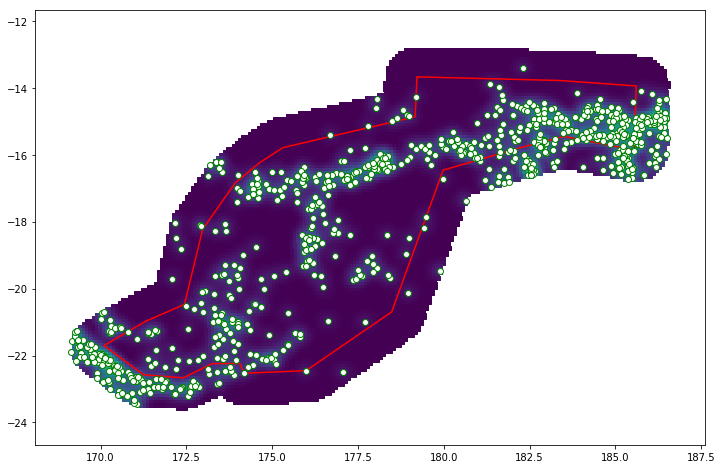

In [16]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot((111))
#
# plotting
plt.scatter(smooth.mesh.lons, smooth.mesh.lats, c=values, vmin=0, vmax=max(values), marker='s', s=15)
#plt.plot(src.polygon.lons, src.polygon.lats, 'r')
plt.plot(lons_poly_sh, src.polygon.lats, 'r')
plt.plot(fcatal.data['longitude'], fcatal.data['latitude'], 'og', mfc='white')
#
# find min and max longitude and latitude of the area source polygon
#lomin = min(src.polygon.lons) - buff
lomin = min(lons_poly_sh) - buff
lamin = min(src.polygon.lats) - buff
#lomax = max(src.polygon.lons) + buff
lomax = max(lons_poly_sh) + buff
lamax = max(src.polygon.lats) + buff
#
# fix axes limits
ax.set_xlim([lomin, lomax])
ax.set_ylim([lamin, lamax])

In [17]:
%%bash
rm tmp*

## Select the nodes of the grid within the area source

In [18]:
idxp = smooth.get_points_in_polygon(src.polygon)

172.977 -18.223 0.0 -2797874.4286300046
173.926119 -16.837119 156767.7339700995 -2556542.9170358465
174.6489 -16.2264 274223.01529561466 -2450624.3530740333
175.3159 -15.7859 381685.15298990224 -2373718.230526065
179.167637 -14.862967 999070.1792822988 -2190184.4020174565
179.2218 -13.6711 994335.2594844955 -1993992.472586427
-176.617737743 -13.7807833609 1656517.357030808 -1951119.2859594328
-174.388587768 -13.9425765043 2012976.676041208 -1932344.713215575
-174.45 -15.862 2047244.370524438 -2249614.348396387
-176.491086 -15.450821 1708534.55587439 -2223189.1402522507
-177.824 -15.8034 1499086.1599398695 -2305640.890795512
179.983 -16.4594 1151095.0491427395 -2448387.5558749707
179.257662394 -18.5076737185 1056652.2890486687 -2811461.9715970242
178.4828 -20.6958 950303.9601327331 -3212966.6076191175
175.9891 -22.4501 530959.4993311266 -3560258.7696223636
174.187 -22.529 213525.54726608488 -3582614.1005333094
174.056 -22.236 189750.47075441873 -3527406.4217245467
173.2539 -22.2418 4869

### Plotting

(-24.666599999999999, -11.671099999999999)

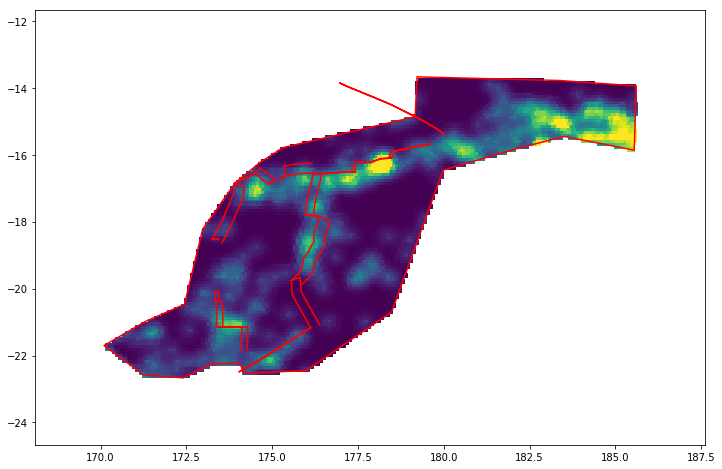

In [19]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot((111))
plt.scatter(smooth.mesh.lons[idxp], smooth.mesh.lats[idxp], vmin=0, vmax=0.4, c=values[idxp], marker='s', s=15)
plt.plot(lons_poly_sh, src.polygon.lats, 'r')
if 'ids_faults_inside' in src.__dict__:
    for iii, key in enumerate(sorted(src.ids_faults_inside.keys())): 
        tsrc = model.sources[key] 
        coord = numpy.array(get_polygon_from_simple_fault(tsrc))
        plt.plot(coord[:,0], coord[:,1], 'r')
#
# fix axes limits
ax.set_xlim([lomin, lomax])
ax.set_ylim([lamin, lamax])

## Assigning seismicity to the source
The redistribution of seismicity to the source is done for each cell using as a scaling factor the ratio of the value assigned to the node and the sum of the values of all the nodes within the area source. Note that the mfd assigned to the area source must be an EvenlyDiscretisedMFD instance.

In [20]:
scaling_factor = 1. /sum(values[idxp])
if isinstance(src.mfd, TruncatedGRMFD):
    newmfd = get_evenlyDiscretizedMFD_from_truncatedGRMFD(src.mfd)
    src.mfd = newmfd
mfdpnts = numpy.array([src.mfd.occurrence_rates]*len(values))*scaling_factor
#
#
xxx = numpy.tile(values, (mfdpnts.shape[1], 1)).T
mfdpnts = mfdpnts * numpy.tile(values, (mfdpnts.shape[1], 1)).T
#
# 
mags = []
for mag, _ in src.mfd.get_annual_occurrence_rates():
    mags.append(mag)   

## Cutting the MFDs of the point sources close to faults

Source: sf_102
-176.462 -15.419 0.0 -2316973.043598458
-176.467816 -15.425364 -945.3401271819413 -2318039.3468836946
-176.473633 -15.431729 -1890.9793310962755 -2319105.8672977076
-176.47945 -15.438093 -2836.755067291124 -2320172.2697066106
-176.485268 -15.444457 -3782.8299402474468 -2321238.721649513
-176.491086 -15.450821 -4729.041414235977 -2322305.223162182
-176.496904 -15.457184 -5675.389442147093 -2323371.6066072807
-176.502722 -15.463548 -6621.874159321736 -2324438.20728707
-176.508541 -15.469911 -7568.658066965107 -2325504.689811323
-176.51436 -15.476274 -8515.578646805652 -2326571.2219097563
-176.52018 -15.482637 -9462.79856305837 -2327637.803493212
-176.526 -15.489 -10410.155209608794 -2328704.43465996
-176.532696 -15.494752 -11500.068122280354 -2329668.5066995663
-176.539393 -15.500504 -12590.285922203997 -2330632.588405016
-176.546091 -15.506255 -13680.80849995836 -2331596.51195947
-176.552788 -15.512007 -14771.310797378872 -2332560.613213228
-176.559486 -15.517758 -15862.1

-174.370962 -15.291459 -17359.35562162682 -2295615.5897137946
-174.36205 -15.293339 -15913.3258502504 -2295931.567079149
-174.353137 -15.295219 -14467.07197807588 -2296247.412377776
-174.344224 -15.297099 -13020.756310730176 -2296563.125410276
-174.335311 -15.298978 -11574.378728085823 -2296878.5389452023
-174.326397 -15.300857 -10127.77709336101 -2297193.820298545
-174.317484 -15.302736 -8681.276037994543 -2297508.969223118
-174.30857 -15.304614 -7234.5508637819075 -2297823.81867919
-174.299657 -15.306492 -5787.926330865019 -2298138.535711443
-174.290743 -15.308369 -4341.077760012974 -2298452.9532062956
-174.281829 -15.310247 -2894.1675960077214 -2298767.4055677536
-174.272914 -15.312124 -1447.0334352634648 -2299081.5583012598
-174.264 -15.314 0.0 -2299395.4113354473
Source: sf_109
-178.768 -14.23 0.0 -2119648.537592976
-178.766749 -14.221286 200.58832387483747 -2118216.1120501217
-178.765498 -14.212572 401.1372147738832 -2116783.880446869
-178.764246 -14.203858 601.8069916384018 -211

-178.919919 -14.364612 20570.04806142778 -2141786.8617110574
-178.917923 -14.355824 20888.536998049512 -2140338.747145099
-178.915927 -14.347036 21206.96262281328 -2138890.8267586287
-178.913931 -14.338248 21525.324948729034 -2137443.1004834035
-178.911936 -14.32946 21843.463450736883 -2135995.5684915646
-178.90994 -14.320671 22161.698983720744 -2134548.065609278
-178.907945 -14.311883 22479.71099715141 -2133100.921532285
-178.90595 -14.303095 22797.65979550403 -2131653.97130081
-178.903955 -14.294307 23115.545391727304 -2130207.2148467414
-178.90196 -14.285519 23433.367798788346 -2128760.652101989
-178.899965 -14.27673 23751.126761636056 -2127314.1184842824
-178.897971 -14.267942 24068.66239904256 -2125867.943241692
-178.895976 -14.259154 24386.29532861649 -2124421.9612429626
-178.893982 -14.250365 24703.704447300017 -2122976.0085075437
-178.891988 -14.241577 25021.05074845714 -2121530.413616978
-178.889994 -14.232788 25338.33368401034 -2120084.8476345716
-178.888 -14.224 25655.553834

-179.427901 -15.466168 2617.9638604228185 -2324878.762850795
-179.425602 -15.457478 2991.5243272608313 -2323421.6836139117
-179.423303 -15.448787 3365.011079868302 -2321964.6328172428
-179.421004 -15.440097 3738.424205716285 -2320507.945674597
-179.418705 -15.431407 4111.763686191974 -2319051.454464161
-179.416407 -15.422716 4484.866949344646 -2317594.9916080325
-179.414109 -15.414026 4857.896676465591 -2316138.8921371587
-179.411811 -15.405335 5230.852776878698 -2314682.8208893645
-179.409513 -15.396644 5603.735316759592 -2313226.9453546014
-179.407215 -15.387954 5976.544379199672 -2311771.4329284113
-179.404918 -15.379263 6349.117391833938 -2310315.9486602033
-179.402621 -15.370572 6721.616921831805 -2308860.659907499
-179.400324 -15.361882 7094.043064913472 -2307405.733995224
-179.398027 -15.353191 7466.395679652866 -2305950.83604446
-179.39573 -15.3445 7838.674857539681 -2304496.1334037385
-179.393434 -15.335809 8210.718237558323 -2303041.6260949858
-179.391138 -15.327119 8582.6883

-179.807462 -15.49503 -161928.38538650438 -2328832.7010750594
-179.815066 -15.48981 -163155.5867507343 -2327943.5071445503
-179.822671 -15.48459 -164382.80390631728 -2327054.2837786935
-179.830275 -15.479369 -165609.70969326125 -2326164.8668823615
-179.837879 -15.474148 -166836.46862334083 -2325275.4223938403
-179.845482 -15.468927 -168062.91809544215 -2324385.9521652944
-179.853085 -15.463705 -169289.2188294225 -2323496.286717985
-179.860688 -15.458484 -170515.37466311877 -2322606.761387154
-179.86829 -15.453262 -171741.21916922292 -2321717.0427616853
-179.875892 -15.448039 -172966.91491749653 -2320827.129024531
-179.883494 -15.442817 -174192.46582894155 -2319937.3554246803
-179.891095 -15.437594 -175417.70542247745 -2319047.3886777028
-179.898696 -15.432371 -176642.79824249807 -2318157.3944989047
-179.906296 -15.427148 -177867.5817662074 -2317267.3748483104
-179.913896 -15.421924 -179092.2165243335 -2316377.1602542107
-179.921495 -15.4167 -180316.54201764934 -2315486.9202764123
-179.

178.630944 -14.585611 -220413.99042253869 -2176612.85476135
178.622844 -14.581383 -221707.37608599386 -2175894.2756022355
178.614744 -14.577155 -223000.63611662723 -2175175.6290771947
178.606644 -14.572926 -224293.7679825589 -2174456.7499264204
178.598545 -14.568698 -225586.61578664443 -2173737.9711894034
178.590446 -14.564469 -226879.33541739493 -2173018.959895185
178.582348 -14.560239 -228171.76589593795 -2172299.718597345
178.57425 -14.55601 -229464.0733192218 -2171580.575302526
178.566152 -14.55178 -230756.25251924503 -2170861.1995617384
178.558054 -14.54755 -232048.3060762419 -2170141.756618186
178.549957 -14.543319 -233340.07045060708 -2169422.0838591326
178.54186 -14.539089 -234631.71182401717 -2168702.509143658
178.533763 -14.534858 -235923.22491211072 -2167982.702113443
178.525666 -14.530627 -237214.61235331828 -2167262.8279663604
178.51757 -14.526395 -238505.7105815719 -2166542.7241918272
178.509474 -14.522163 -239796.68315441432 -2165822.5533688976
178.501379 -14.517931 -241

178.409725 -14.475202 -255707.11618689136 -2157798.776137515
178.418192 -14.478888 -254356.39638979553 -2158430.770251815
178.42666 -14.482574 -253005.40086676486 -2159062.6778332763
178.435127 -14.48626 -251654.45119628447 -2159694.4932881156
178.443595 -14.489945 -250303.22296233868 -2160326.057112949
178.452063 -14.493631 -248951.8826277627 -2160957.696595305
178.460531 -14.497315 -247600.42175882534 -2161588.9165564612
178.469 -14.501 -246248.68796604488 -2162220.214863593
178.477094 -14.505233 -244958.6680668809 -2162940.880374983
178.485189 -14.509466 -243668.3616842733 -2163661.4816422663
178.493284 -14.513699 -242377.9296424924 -2164382.0159469685
178.501379 -14.517931 -241087.36921587898 -2165102.3181592366
178.509474 -14.522163 -239796.68315441022 -2165822.5533688976
178.51757 -14.526395 -238505.7105815719 -2166542.7241918272
178.525666 -14.530627 -237214.61235331828 -2167262.8279663604
178.533763 -14.534858 -235923.22491211072 -2167982.702113443
178.54186 -14.539089 -234631.

174.101866 -16.753862 -66194.04230277988 -2542945.734722526
174.110231 -16.749894 -64810.74414332355 -2542272.1755571123
174.118596 -16.745925 -63427.570014126235 -2541598.362679387
174.12696 -16.741956 -62044.68566444557 -2540924.4666896006
174.135324 -16.737987 -60661.92608475363 -2540250.4883109783
174.143688 -16.734017 -59279.29059732793 -2539576.2563371286
174.152051 -16.730047 -57896.94488174678 -2538901.941380022
174.160414 -16.726077 -56514.72395070945 -2538227.544117223
174.168777 -16.722106 -55132.62717389032 -2537552.893376277
174.177139 -16.718135 -53750.8201611738 -2536878.1597808315
174.185501 -16.714164 -52369.13794751695 -2536203.3439628095
174.193863 -16.710192 -50987.579949953986 -2535528.274783698
174.202224 -16.70622 -49606.311708681926 -2534853.122878811
174.210585 -16.702248 -48225.16828093365 -2534177.888834452
174.218946 -16.698275 -46844.149131082915 -2533502.4015460345
174.227306 -16.694302 -45463.41972966259 -2532826.8316605208
174.235666 -16.690328 -44082.81

174.940527 -16.841773 -27498.59899982597 -2558134.6600444596
174.948458 -16.83731 -26187.19421720117 -2557371.5070170104
174.956389 -16.832848 -24875.923230995082 -2556608.4682298196
174.964319 -16.828385 -23564.950610876265 -2555845.20041547
174.972249 -16.823922 -22254.111476109258 -2555081.8753833384
174.980178 -16.819458 -20943.570723756904 -2554318.3214473035
174.988108 -16.814994 -19632.998326931138 -2553554.71057829
174.996036 -16.81053 -18322.88967948319 -2552791.0421353173
175.003965 -16.806066 -17012.74937753582 -2552027.316773654
175.011893 -16.801601 -15702.90747738054 -2551263.362700068
175.01982 -16.797136 -14393.36415810234 -2550499.3514021146
175.027748 -16.792671 -13083.789207622842 -2549735.2832181137
175.035675 -16.788205 -11774.512676665734 -2548970.9864797234
175.043601 -16.783739 -10465.534699423983 -2548206.632636048
175.051527 -16.779273 -9156.690179915611 -2547442.221838182
175.059453 -16.774806 -7847.979023510596 -2546677.5827585794
175.067378 -16.770339 -6539

175.788935099 -16.2684841112 -64832.59125569853 -2460153.528614375
175.797998245 -16.2675781113 -63344.62829148899 -2460005.9967116807
175.807062391 -16.2666711115 -61856.530577884034 -2459858.1494448544
175.816126537 -16.2657641116 -60368.46299911207 -2459710.1559997015
175.825190682 -16.2648561117 -58880.42487217826 -2459561.846495794
175.834253828 -16.2639481119 -57392.58103925008 -2459413.3901958796
175.843316974 -16.263040112 -55904.76741418217 -2459264.7877687216
175.85238112 -16.2621311122 -54416.819271090324 -2459115.869940187
175.861444266 -16.2612221123 -52929.065493358205 -2458966.805383137
175.870538295 -16.2610411123 -51436.70096839046 -2458941.2801356604
175.879632325 -16.2608591124 -49944.341487291036 -2458915.4357507625
175.888726354 -16.2606771124 -48451.98769432049 -2458889.4421042297
175.897820383 -16.2604941124 -46959.63904306329 -2458863.1293238443
175.906914413 -16.2603111124 -45467.29614377205 -2458836.667284495
175.916008442 -16.2601281125 -43974.959011369836 -2

176.275901 -16.560118 -187057.51977470287 -2508792.76777922
176.285091 -16.560927 -185546.18638598057 -2508949.712046525
176.294282 -16.561736 -184034.65854615666 -2509106.5075329635
176.303472 -16.562545 -182523.26555601577 -2509263.1501672114
176.312663 -16.563353 -181011.6760757067 -2509419.4732605875
176.321854 -16.564161 -179500.05686372865 -2509575.645496574
176.331045 -16.564969 -177988.40793494327 -2509731.666870812
176.340235 -16.565776 -176476.89194303774 -2509887.3647114374
176.349427 -16.566582 -174965.01499731842 -2510042.744832566
176.358618 -16.567389 -173453.27507992057 -2510198.1428574477
176.367809 -16.568195 -171941.5035777792 -2510353.2192651867
176.377 -16.569 -170429.70055749817 -2510507.9740439653
176.386334 -16.568337 -168891.49248118224 -2510412.2034038096
176.395668 -16.567673 -167353.30398124375 -2510316.105157432
176.405001 -16.567009 -165815.30167431096 -2510219.84821905
176.414335 -16.566345 -164277.15626302006 -2510123.4362583105
176.423669 -16.56568 -162

177.990629 -16.178254 -82029.47109166329 -2444750.268197962
177.982443 -16.181381 -83374.41668433379 -2445273.298462417
177.974256 -16.184508 -84719.62127537176 -2445796.233764335
177.96607 -16.187634 -86064.75599261127 -2446318.9062772626
177.957883 -16.190759 -87410.14868655382 -2446841.314086391
177.949696 -16.193885 -88755.63738201027 -2447363.797456713
177.941508 -16.19701 -90101.38403938517 -2447886.016027767
177.933321 -16.200135 -91447.06171600075 -2448408.1414337223
177.925133 -16.203259 -92792.99729755758 -2448930.0019572293
177.916945 -16.206384 -94139.02890857073 -2449451.937991851
177.908756 -16.209508 -95485.31840968617 -2449973.6090485537
177.900568 -16.212631 -96831.53777079566 -2450495.017178558
177.892379 -16.215754 -98178.01605242708 -2451016.3299748763
177.884189 -16.218877 -99524.75326824014 -2451537.547383607
177.876 -16.222 -100871.42139971875 -2452058.671570873
177.86725 -16.222626 -102307.29096681629 -2452155.161398203
177.8585 -16.223252 -103743.1800582083 -24

178.570908 -15.894984 -170448.49890387445 -2396054.963529952
178.562 -15.897 -171908.00412667682 -2396378.576857385
178.562 -15.897 -171908.00412667682 -2396378.576857385
178.570908 -15.894984 -170448.49890387445 -2396054.963529952
178.579817 -15.892967 -168988.89358820042 -2395731.0510312053
178.588725 -15.89095 -167529.5169411934 -2395407.004483209
178.597633 -15.888933 -166070.2055738417 -2395082.8257704116
178.60654 -15.886915 -164611.12101075856 -2394758.3442686237
178.615448 -15.884897 -163151.93839299862 -2394433.7324578804
178.624355 -15.882878 -161692.98266032842 -2394108.8179294453
178.633262 -15.880859 -160234.09230968397 -2393783.7713250834
178.642169 -15.87884 -158775.26735181146 -2393458.5926535805
178.651076 -15.876821 -157316.50779747285 -2393133.281923731
178.659983 -15.874801 -155857.8118853693 -2392807.6703552427
178.668889 -15.87278 -154399.34303654896 -2392481.756274113
178.677795 -15.87076 -152940.94142159238 -2392155.878993038
178.686701 -15.868738 -151482.601834

173.890209 -17.010487 105789.836385029 -2586767.8566586594
173.890809 -17.001516 105878.27171245607 -2585224.1728255684
173.891409 -16.992544 105966.68709066071 -2583680.5495857303
173.892009 -16.983573 106055.08494637955 -2582137.330796684
173.892608 -16.974601 106143.29742849601 -2580594.173651944
173.893208 -16.96563 106231.65784554264 -2579051.419570146
173.893808 -16.956658 106319.99832561368 -2577508.7258477556
173.894408 -16.947687 106408.32130304935 -2575966.436134738
173.895007 -16.938715 106496.45898701168 -2574424.207836285
173.895607 -16.929744 106584.74455783483 -2572882.3821558286
173.896206 -16.920772 106672.8448752191 -2571340.617775231
173.896806 -16.911801 106761.09305542699 -2569799.255790423
173.897405 -16.902829 106849.1560222135 -2568257.95499087
173.898004 -16.893858 106937.2015499961 -2566717.0575418584
173.898604 -16.884886 107025.3924599579 -2565176.2188100754
173.899203 -16.875915 107113.40066298813 -2563635.7843857026
173.899802 -16.866943 107201.38899343305

173.347116 -20.306456 -667.7474115205476 -3170558.4788647606
173.34663 -20.297637 -751.2245207030778 -3168951.4695629836
173.346145 -20.288819 -834.5125774167724 -3167344.8998449175
173.34566 -20.280001 -917.7835005906743 -3165738.5873734048
173.345175 -20.271183 -1001.0372943510336 -3164132.532054113
173.34469 -20.262365 -1084.2739628045947 -3162526.7337927585
173.344205 -20.253547 -1167.4935100779544 -3160921.192495096
173.34372 -20.244729 -1250.6959402694627 -3159315.9080669098
173.343235 -20.23591 -1333.88124193691 -3157710.6984122344
173.34275 -20.227092 -1417.0494493311255 -3156105.927469753
173.342265 -20.218274 -1500.2005519661575 -3154501.4131143913
173.341781 -20.209456 -1583.1628256944448 -3152897.1552695446
173.341296 -20.200638 -1666.279748783336 -3151293.1538072852
173.340811 -20.191819 -1749.379559024417 -3149689.226794002
173.340327 -20.183001 -1832.2906250231379 -3148085.73789739
173.339842 -20.174183 -1915.3562997134359 -3146482.5050988877
173.339358 -20.165365 -1998.

173.540067748 -20.4241817527 27729.239063977016 -3192010.7446607323
173.541255228 -20.433038708 27936.5622744498 -3193628.0269461125
173.542443714 -20.4418966633 28144.101910670204 -3195245.750392948
173.543632205 -20.4507536186 28351.684762554232 -3196863.55006286
173.544820701 -20.4596105739 28559.31137094071 -3198481.6087062466
173.546009203 -20.4684675292 28766.981746817113 -3200099.9264187873
173.547197711 -20.4773244844 28974.69590111483 -3201718.503296178
173.548386225 -20.4861824397 29182.454390175862 -3203337.522266294
173.549575743 -20.495039395 29390.42843797505 -3204956.6174668577
173.550764267 -20.5038963503 29598.274013835082 -3206575.9724407964
173.551953797 -20.5127533055 29806.335748820286 -3208195.586634857
173.553143332 -20.5216102608 30014.441352806785 -3209815.4604683807
173.554332873 -20.530467216 30222.590836788426 -3211435.594037336
173.555522419 -20.5393241713 30430.784211790717 -3213055.9874377293
173.556712971 -20.5481811265 30639.193896909557 -3214676.640428

174.092938 -21.805934 514.0662742509203 -3447623.9762517945
174.093672 -21.797167 642.4289869783436 -3445981.4563253946
174.094406 -21.788401 770.765188351285 -3444339.393992141
174.09514 -21.779634 899.0748682740311 -3442697.414509908
174.095874 -21.770868 1027.3580529902379 -3441055.892359116
174.096608 -21.762101 1155.6147263442729 -3439414.4529214525
174.097342 -21.753335 1283.8449206069877 -3437773.470553748
174.098076 -21.744568 1412.0486135846331 -3436132.5707614124
174.09881 -21.735801 1540.2258254438243 -3434491.940657567
174.099543 -21.727035 1668.2017734284047 -3432851.767250243
174.100277 -21.718268 1796.3260622175428 -3431211.67619494
174.10101 -21.709501 1924.249116640727 -3429571.854550401
174.101743 -21.700735 2052.1457763310045 -3427932.4891955387
174.102476 -21.691968 2180.0160009833585 -3426293.2060063854
174.10321 -21.683201 2308.0345385117607 -3424654.1918857275
174.103943 -21.674435 2435.851968592337 -3423015.633687956
174.104676 -21.665668 2563.6429786752396 -342

174.907975 -21.960321 -212625.1864001099 -3475174.1442611422
174.900085 -21.965443 -214021.03437634392 -3476118.0811568205
174.892194 -21.970564 -215417.22188219184 -3477061.7986889947
174.884302 -21.975686 -216813.75402890367 -3478005.672659256
174.87641 -21.980806 -218210.44787133898 -3478949.1415657946
174.868517 -21.985926 -219607.48383273493 -3479892.5788576636
174.860624 -21.991046 -221004.6866211046 -3480835.9869189225
174.85273 -21.996166 -222402.23159764885 -3481779.3633004106
174.844836 -22.001285 -223799.94080874248 -3482722.5223752577
174.836941 -22.006404 -225197.99224404016 -3483665.6496692034
174.829045 -22.011522 -226596.3832744512 -3484608.557056623
174.821149 -22.01664 -227994.9411969595 -3485551.435040109
174.813252 -22.021758 -229393.8414246503 -3486494.2810935387
174.805355 -22.026875 -230792.90586898313 -3487436.9095769404
174.797457 -22.031992 -232192.31265446125 -3488379.5060290447
174.789559 -22.037108 -233591.88363856476 -3489321.88480466
174.78166 -22.042224 

175.560692 -21.534922 -97725.01977991851 -3396673.0594071783
175.56853 -21.529793 -96352.17489017853 -3395725.3657783167
175.576368 -21.524664 -94979.49475724243 -3394777.645069049
175.584204 -21.519534 -93607.32702576245 -3393829.7088618944
175.592041 -21.514404 -92235.14964544201 -3392881.7466885345
175.599876 -21.509274 -90863.4857100332 -3391933.755505644
175.607712 -21.504143 -89491.81104628822 -3390985.552054204
175.615546 -21.499012 -88120.64977003288 -3390037.319722584
175.62338 -21.49388 -86749.65213031851 -3389088.874242176
175.631214 -21.488748 -85378.81916588965 -3388140.401920116
175.639047 -21.483616 -84008.32516965645 -3387191.901833532
175.646879 -21.478483 -82638.16912516636 -3386243.1878126897
175.654711 -21.47335 -81268.1777057735 -3385294.447050831
175.662543 -21.468217 -79898.35089789139 -3384345.6795495264
175.670373 -21.463083 -78529.03629424053 -3383396.6974188667
175.678204 -21.457949 -77159.71201118335 -3382447.6894968376
175.686033 -21.452815 -75790.900797976

175.57733 -20.020376 -93157.51743013604 -3118281.085206304
175.576664 -20.0115 -93261.99677070799 -3116671.4096106086
175.575998 -20.002625 -93366.45515706747 -3115062.1726479796
175.575332 -19.99375 -93470.89150969821 -3113453.1929346337
175.574666 -19.984875 -93575.30583370065 -3111844.47037586
175.574 -19.976 -93679.69813417253 -3110236.004876998
175.573399 -19.96716 -93772.97594304621 -3108634.202436589
175.572798 -19.95832 -93866.23411038611 -3107032.6549805994
175.572198 -19.94948 -93959.30143477146 -3105431.363449494
175.571597 -19.94064 -94052.52035017214 -3103830.3256829907
175.570997 -19.931801 -94145.54956232253 -3102229.724655855
175.570396 -19.922961 -94238.72924479097 -3100629.1961764586
175.569796 -19.914121 -94331.71817271832 -3099028.9232526277
175.569195 -19.905281 -94424.85863917248 -3097428.9037160245
175.568595 -19.896441 -94517.80839528951 -3095829.1395505704
175.567995 -19.887601 -94610.73858101021 -3094229.629625025
175.567395 -19.878761 -94703.64920082287 -3092

175.67525 -19.641577 19831.92821622912 -3050107.629437741
175.681703 -19.635274 20931.25915867336 -3048971.325569985
175.688156 -19.62897 22030.428748763192 -3047834.891873084
175.694609 -19.622666 23129.437238573857 -3046698.508391165
175.701061 -19.616362 24228.114102698422 -3045562.1753745894
175.707512 -19.610057 25326.459106271832 -3044425.7128846887
175.713963 -19.603753 26424.64340607239 -3043289.48058838
175.720414 -19.597448 27522.666422869963 -3042153.118572372
175.726864 -19.591143 28620.357975349587 -3041016.807094046
175.733314 -19.584837 29717.888262277687 -3039880.3659689883
175.739763 -19.578532 30815.087510588164 -3038744.1552951206
175.746211 -19.572226 31911.955076660455 -3037607.8153579826
175.752659 -19.56592 33008.66181180972 -3036471.525691666
175.759107 -19.559613 34105.20734178031 -3035335.1064838013
175.765554 -19.553307 35201.4220452607 -3034198.9177180626
175.772 -19.547 36297.30517687508 -3033062.5998424515
175.776789 -19.539715 37110.2583672487 -3031751.23

176.394469504 -18.9680558503 141418.53460086524 -2928920.6792101883
176.390732894 -18.9762057274 140799.33457071017 -2930376.53031473
176.386995289 -18.9843546044 140179.84705025176 -2931832.3885587812
176.383258693 -18.9925034815 139560.412546507 -2933288.4288176186
176.379520106 -19.0006533585 138940.5250287959 -2934744.833768404
176.375782526 -19.0088022355 138320.688546425 -2936201.2428784673
176.370741671 -19.0162741228 137478.93539865696 -2937539.2622267203
176.365699821 -19.02374501 136636.8656400657 -2938877.2344780504
176.36065798 -19.0312168972 135794.65240168106 -2940215.5142886047
176.355615143 -19.0386877844 134952.1224611873 -2941553.7470021397
176.350572313 -19.0461586716 134109.44706774649 -2942892.109237044
176.34552949 -19.0536295588 133266.62619566894 -2944230.6010354282
176.340485673 -19.061100446 132423.4903724153 -2945569.223896639
176.335441863 -19.0685713332 131580.20898958025 -2946907.976387034
176.330397057 -19.0760412203 130736.61070991289 -2948246.6817421825

175.973868 -17.786467 144.93957229482643 -2721500.990801804
175.974302 -17.7777 217.38746661752137 -2719973.0334819136
175.974736 -17.768934 289.8207741109098 -2718445.479778939
175.975169 -17.760167 362.07256158614183 -2716917.981097422
175.975603 -17.751401 434.4767179151477 -2715390.8858135226
175.976037 -17.742634 506.86628977465466 -2713863.845435791
175.97647 -17.733867 579.0744043820455 -2712337.0341083165
175.976904 -17.725101 651.4348497539586 -2710810.6258522226
175.977338 -17.716334 723.7807180151199 -2709284.2723355466
175.977771 -17.707568 795.9451983781012 -2707758.3216889193
175.978205 -17.698801 868.261953162741 -2706232.4256627015
175.978638 -17.690034 940.3973510422975 -2704706.758282291
175.979071 -17.681268 1012.5182367533151 -2703181.49344157
175.979505 -17.672501 1084.7913538354644 -2701656.283052501
175.979938 -17.663734 1156.8831741770841 -2700131.301066984
175.980371 -17.654968 1228.960494619661 -2698606.7212983645
175.980805 -17.646201 1301.1900034106898 -2697

176.402193275 -16.7842204687 70848.8380973086 -2548125.48043219
176.400380111 -16.7928083936 70556.45474357737 -2549598.6223107106
176.398567952 -16.8013963185 70264.17978048038 -2551071.9695046875
176.396754801 -16.8099852434 69971.68400932944 -2552545.695067049
176.394940656 -16.8185731682 69678.96535052374 -2554019.456221987
176.393127516 -16.8271610931 69386.35506349568 -2555493.422911427
176.391314383 -16.835749018 69093.68801466998 -2556967.595977355
176.389500257 -16.8443369429 68800.79900561535 -2558441.9762488944
176.387686137 -16.8529248677 68507.85317887788 -2559916.5630345596
176.38536463 -16.8612027953 68130.77808571103 -2561338.547172832
176.383044129 -16.8694807228 67753.79748728852 -2562760.718412956
176.380722634 -16.8777586504 67376.58091666881 -2564183.078313675
176.378400145 -16.8860365779 66999.12831276438 -2565605.626926001
176.376078661 -16.8943145055 66621.77017692037 -2567028.3628347325
176.373756184 -16.902592433 66244.1759482265 -2568451.287573771
176.3714337

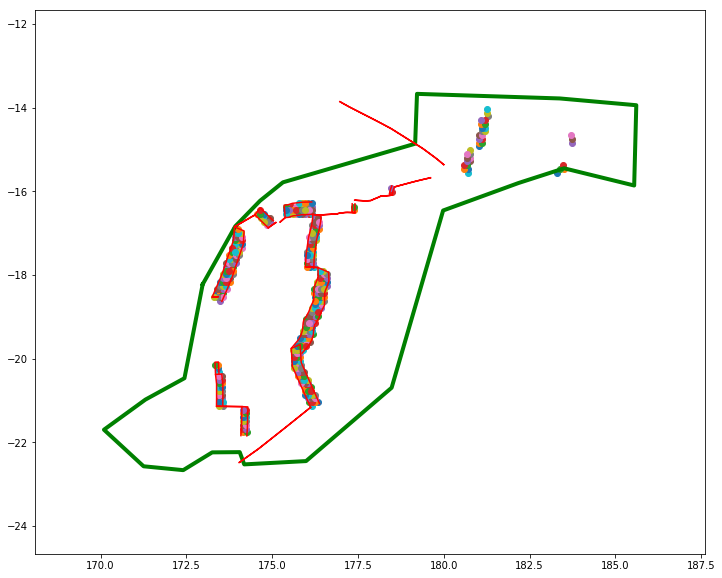

In [21]:
# use only with faults
faultcheck = False
inc_faults = len(src.ids_faults_inside)
if inc_faults>0:
    faultcheck = True
    
    
if faultcheck == True:    
    # To select a different smoothing buffer value 
    smoothing_buffer = model.smoothing_buffer
    #
    #
    # find index of magnitudes above the threshold
    jjj = numpy.nonzero(numpy.array(mags) > faults_lower_threshold_magnitude)
    chng = numpy.zeros_like((values))
    #
    # create figure
    fig = plt.figure(figsize=(12, 10))
    ax = plt.subplot(111)
    #
    #
    if hasattr(src, 'ids_faults_inside'):
        for iii, key in enumerate(sorted(src.ids_faults_inside.keys())): 
            #
            # Getting the fault source
            tsrc = model.sources[key]
            print('Source:', key)

            if 'mfd' in tsrc.__dict__ and tsrc.mfd is not None:

                lons, lats = get_xy(tsrc.trace) 
                lons = ([x+360 if x<0 else x for x in lons])

                # Create the polygon representing the surface projection of the fault
                # surface
                coord = numpy.array(get_polygon_from_simple_fault(tsrc))
                #
                #
                min_lon = numpy.min(lons)-buff
                max_lon = numpy.max(lons)+buff
                min_lat = numpy.min(lats)-buff
                max_lat = numpy.max(lats)+buff

                #print(min_lon,max_lon)

                idxs = list(smooth.rtree.intersection((min_lon, min_lat, max_lon, max_lat)))

                iii = get_idx_points_inside_polygon(smooth.mesh.lons[idxs], 
                                                    smooth.mesh.lats[idxs],
                                                    list(coord[:,0]), 
                                                    list(coord[:,1]), 
                                                    idxs,
                                                    smoothing_buffer) 

                for tidx in iii:
                    plt.plot(smooth.mesh.lons[tidx], smooth.mesh.lats[tidx], 'o')
                    mfdpnts[tidx, jjj] = 0.
                    chng[tidx] = 1.

    plt.plot(lons_poly_sh, src.polygon.lats, 'g', lw=4)
    for iii, key in enumerate(sorted(src.ids_faults_inside.keys())): 
            tsrc = model.sources[key]
            lons, lats = get_xy(tsrc.trace) 
            coord = numpy.array(get_polygon_from_simple_fault(tsrc))
            plt.plot(coord[:,0], coord[:,1], 'r')
    #
    # fix axes limits
    ax.set_xlim([lomin, lomax])
    ax.set_ylim([lamin, lamax])

## Map

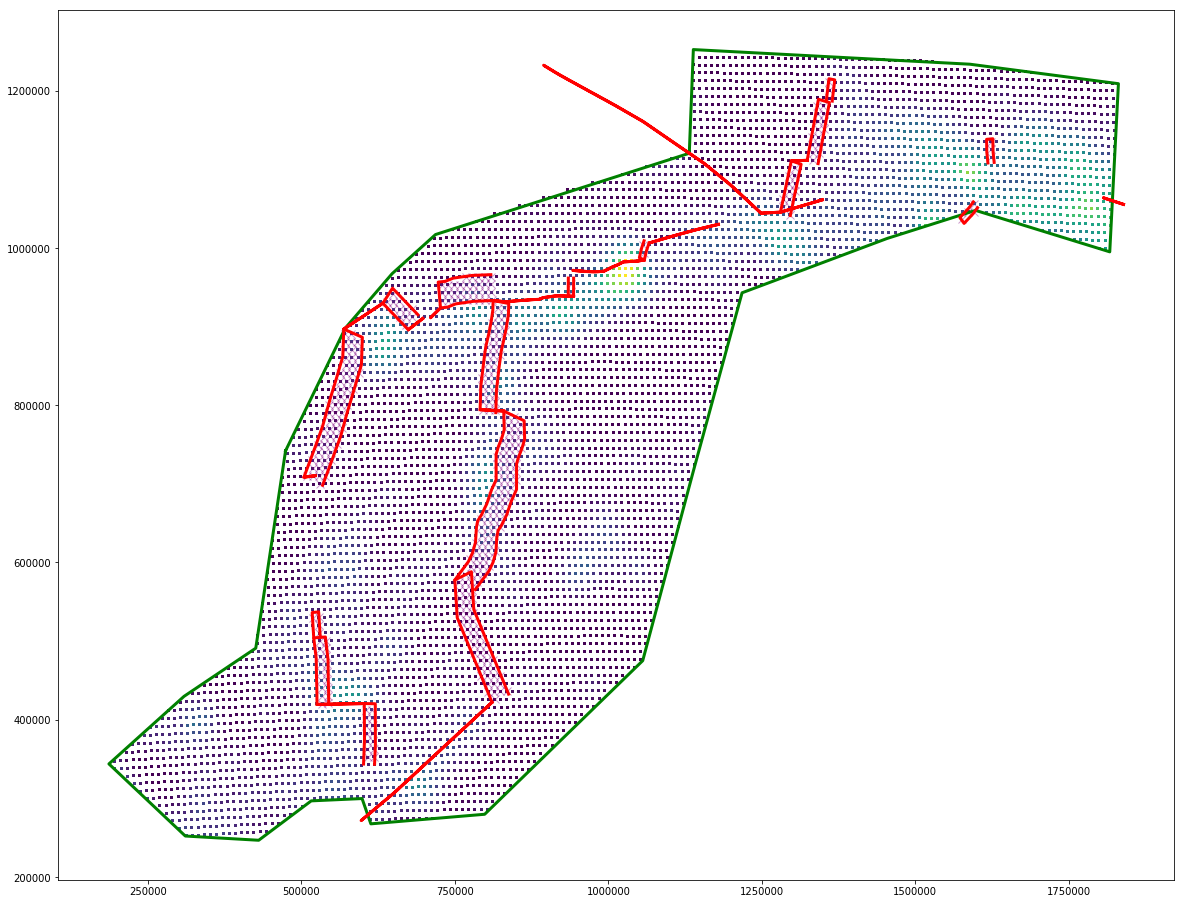

In [27]:
#use only with faults inside area
from mpl_toolkits.basemap import Basemap
meanlon = 0.5*(lomin+lomax)
meanlat = 0.5*(lamax+lamin)
if faultcheck==True:
    fig = plt.figure(figsize=(20,16))
    m = Basemap(llcrnrlon=lomin,
                llcrnrlat=lamin,
                urcrnrlon=lomax,
                urcrnrlat=lamax,
                resolution='i',
                projection='tmerc',
                lon_0=meanlon,
                lat_0=meanlat)

    #m.shadedrelief()
    x, y = m(smooth.mesh.lons, smooth.mesh.lats)
    rtes = numpy.sum(mfdpnts, axis=1)
    plt.scatter(x[idxp], y[idxp], s=19, marker='s', c=rtes[idxp], lw=0.)

    parallels = numpy.arange(lamin, lamax, 5.)
    #m.drawparallels(parallels,labels=[False,True,True,False])
    meridians = numpy.arange(90, lomax, 5.)
    #m.drawmeridians(meridians,labels=[True,False,False,True])

    jjj = numpy.nonzero(chng > 0)
    plt.plot(x[jjj], y[jjj], 'x', lw=0.8, alpha=0.4, ms=8, markerfacecolor='None', markeredgecolor='purple')

    x, y = m(src.polygon.lons, src.polygon.lats)        
    plt.plot(x, y, 'g', lw=3)

    for iii, key in enumerate(sorted(src.ids_faults_inside.keys())):     
        tsrc = model.sources[key]
        coord = numpy.array(get_polygon_from_simple_fault(tsrc))
        x, y = m(coord[:,0], coord[:,1])
        if 'mfd' in tsrc.__dict__ and tsrc.mfd is not None:
            plt.plot(x, y, 'r', lw=3)
        else:
            plt.plot(x, y, '-', color='pink')

# Create the nrml sources 

In [27]:
lons_sh = smooth.mesh.lons
lons_un = ([x-360 if x>180 else x for x in lons_sh])
smooth.mesh.lons = numpy.array(lons_un)

In [28]:
# Id of the source is created as:
# "ds_src_id_iterator". In this the point sources are related to the area_source with an unique Id by source

nrmls = [] 

import importlib
module = importlib.import_module('openquake.hazardlib.scalerel')
my_class = getattr(module, model.msr)
magnitude_scaling_relationship = my_class()

rupture_mesh_spacing = model.fault_rupture_mesh_spacing
rupture_aspect_ratio = model.fault_rupt_aspect_ratio
temporal_occurrence_model = PoissonTOM(1.)

for eee, iii in enumerate(idxp):
    jjj = numpy.nonzero(mfdpnts[iii, :] > 0)
    
    if len(list(mfdpnts[iii, jjj][0])) > 0:
        tmfd = EvenlyDiscretizedMFD(src.mfd.min_mag, src.mfd.bin_width, list(mfdpnts[iii, jjj][0]))

        points = PointSource(
            source_id='ds_%s_%d' % (src_id, eee), 
            name='', 
            tectonic_region_type=src.tectonic_region_type,
            mfd=tmfd, 
            rupture_mesh_spacing=rupture_mesh_spacing,
            magnitude_scaling_relationship=magnitude_scaling_relationship, 
            rupture_aspect_ratio=rupture_aspect_ratio,
            temporal_occurrence_model=temporal_occurrence_model,
            upper_seismogenic_depth=model.upper_seismogenic_depth, 
            lower_seismogenic_depth=src.lower_seismogenic_depth,
            location=Point(smooth.mesh.lons[iii], smooth.mesh.lats[iii]), 
            nodal_plane_distribution=nodal_plane_distribution, 
            hypocenter_distribution=hypocenter_distribution
            )
        nrmls.append(points)

In [29]:
import re
from openquake.hazardlib.sourcewriter import write_source_model
# Write the nrml file
model_dir = os.path.join(oqtkp.directory, 'nrml/%s' % (re.sub('\s','_',model_id)))
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_name = 'gridded_seismicity_source_%s.xml' % (src_id)
out_model_name = os.path.join(model_dir, model_name)
_ = write_source_model(out_model_name, nrmls, 'Model %s')
print('Created %s ' % (out_model_name))

Created /Users/kjohnson/GEM/Regions/paisl18/project_9/nrml/model09/gridded_seismicity_source_10.xml 
